<a href="https://colab.research.google.com/github/park-geun-hyeong/Kaggle_project/blob/main/Computer-Vision/sign_language_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Train, Test data 확인

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os 
from tqdm import tqdm
import cv2

In [2]:
path = '/content/drive/MyDrive/Kaggle/Computer_Vision/Sign_Language_MNIST/'

train=pd.read_csv(path+'sign_mnist_train.csv')
test=pd.read_csv(path+'sign_mnist_test.csv')

In [3]:
train

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,156,158,160,163,165,159,166,168,170,170,171,171,171,172,171,171,170,170,169,111,121,129,135,141,144,148,151,154,157,160,...,205,206,206,207,207,206,206,204,205,204,203,202,142,151,160,172,196,188,188,190,135,96,86,77,77,79,176,205,207,207,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,157,158,156,154,154,153,152,151,149,149,148,147,146,144,142,143,138,92,108,158,159,159,159,160,160,160,160,160,160,160,...,100,78,120,157,168,107,99,121,133,97,95,120,135,116,95,79,69,86,139,173,200,185,175,198,124,118,94,140,133,84,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,186,185,185,185,184,184,184,181,181,179,179,179,178,178,109,52,66,77,83,188,189,189,188,188,189,188,188,188,188,187,...,203,204,203,201,200,200,199,198,196,195,194,193,198,166,132,114,89,74,79,77,74,78,132,188,210,209,206,205,204,203,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,211,209,207,208,207,206,203,202,201,200,198,197,195,192,197,171,51,52,54,212,213,215,215,212,212,213,212,212,211,211,...,247,242,233,231,230,229,227,225,223,221,220,216,58,51,49,50,57,60,17,15,18,17,19,1,159,255,237,239,237,236,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,186,188,189,189,190,191,189,190,190,187,190,192,193,191,191,192,192,194,194,166,169,172,174,177,180,182,185,186,187,190,...,90,77,88,117,123,127,129,134,145,152,156,179,105,106,105,104,104,104,175,199,178,152,136,130,136,150,118,92,85,76,92,105,105,108,133,163,157,163,164,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27450,13,189,189,190,190,192,193,193,193,193,194,193,193,194,194,195,195,196,194,195,196,196,197,196,197,197,196,195,195,189,190,192,192,193,194,195,196,196,196,193,...,115,92,132,173,118,84,53,135,253,213,219,208,82,82,84,85,85,87,84,87,78,113,216,189,172,175,155,131,116,93,132,165,99,77,52,200,234,200,222,225
27451,23,151,154,157,158,160,161,163,164,166,167,169,169,169,169,169,169,169,169,169,167,167,167,166,165,164,164,163,162,153,156,159,160,162,163,164,165,167,169,172,...,199,200,199,199,198,199,198,197,196,195,195,194,66,67,65,62,61,41,32,37,33,30,28,38,187,202,199,199,199,199,198,198,198,198,198,196,195,195,195,194
27452,18,174,174,174,174,174,175,175,174,173,173,173,172,171,171,171,170,169,168,166,166,165,165,163,162,161,160,158,156,178,178,177,176,177,177,177,176,176,176,175,...,110,85,90,166,205,207,205,203,202,201,200,198,217,217,217,218,218,211,203,200,189,171,157,145,136,129,128,125,101,77,121,196,209,208,206,204,203,202,200,200
27453,17,177,181,184,185,187,189,190,191,191,190,191,193,192,191,191,191,191,190,190,189,187,186,184,183,182,181,179,177,179,182,185,187,189,190,192,192,192,192,194,...,190,173,140,80,28,60,70,61,61,78,100,86,136,135,135,135,132,132,136,136,137,144,103,120,197,200,195,196,170,149,119,56,27,58,102,79,47,64,87,93


In [4]:
test

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,152,152,152,152,152,153,153,151,152,152,153,152,152,151,151,150,150,150,149,150,150,150,152,152,151,152,152,152,152,152,...,131,134,144,147,125,87,87,103,107,110,116,113,75,74,74,74,76,74,82,134,168,155,146,137,145,146,149,135,124,125,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,138,137,137,138,138,139,137,142,140,138,139,137,137,136,135,134,133,134,132,129,132,134,135,135,137,139,139,139,140,141,...,114,112,89,48,133,194,182,185,184,184,182,181,172,174,177,178,178,179,181,183,187,175,165,154,118,107,100,75,96,83,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,152,157,163,168,171,182,172,175,185,183,184,185,185,185,183,183,182,181,178,86,88,93,96,108,125,137,145,149,154,160,...,145,123,78,162,239,227,229,226,226,225,224,222,89,91,94,111,136,154,167,184,125,3,166,225,195,188,172,185,161,122,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,209,208,207,207,209,208,210,210,207,209,209,208,209,210,209,207,208,209,207,206,208,209,208,208,210,211,210,211,209,209,...,85,80,84,151,238,255,255,250,237,245,250,232,103,101,102,103,95,208,231,227,209,190,179,182,152,150,159,119,83,63,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,203,204,204,204,203,202,198,216,217,135,181,200,195,194,193,190,189,187,185,190,194,196,197,200,202,204,206,207,207,206,...,93,52,24,53,63,33,41,51,48,45,49,55,149,150,150,148,147,151,124,82,84,81,69,81,111,103,84,75,53,28,26,40,64,48,29,46,49,46,46,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7167,1,135,119,108,102,105,99,61,103,121,133,143,148,156,160,162,164,168,171,173,175,178,179,181,182,184,185,185,186,137,116,111,101,110,92,66,108,124,132,155,...,147,132,115,112,117,118,112,153,189,178,173,166,140,121,157,125,93,99,100,101,104,100,118,167,154,141,136,139,135,125,108,112,116,114,118,180,184,176,167,163
7168,12,157,159,161,164,166,166,171,174,175,176,176,176,178,176,176,178,177,176,178,178,177,176,176,176,174,174,173,173,159,163,164,166,168,169,173,175,177,178,177,...,90,78,191,215,212,214,212,209,209,208,208,207,189,192,196,199,191,208,230,201,197,185,184,187,169,136,131,107,69,127,213,213,213,214,213,211,210,210,209,208
7169,2,190,191,190,191,190,190,192,192,191,192,193,192,191,192,191,191,192,189,189,189,188,188,188,187,186,185,184,183,193,193,193,193,193,193,194,194,193,195,195,...,215,215,215,214,213,213,212,212,210,209,208,207,215,215,207,207,208,207,203,196,170,99,92,92,89,155,213,216,216,216,216,215,213,214,214,213,210,211,209,208
7170,4,201,205,208,209,214,216,218,223,226,229,234,233,233,237,237,237,240,241,238,240,240,242,243,241,239,239,239,239,206,209,212,215,218,220,223,226,227,229,236,...,168,173,128,127,255,255,255,255,159,99,80,77,255,255,255,255,255,255,231,255,255,255,255,255,249,231,188,164,169,176,112,169,255,255,237,113,91,67,70,63


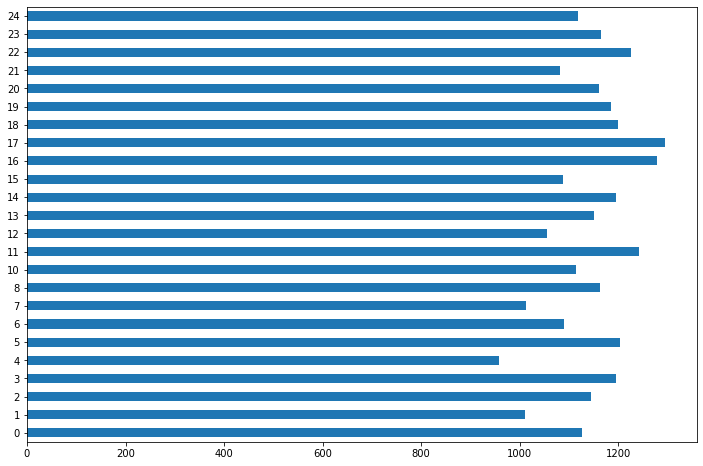

In [5]:
plt.figure(figsize=(12,8))
train['label'].value_counts().sort_index().plot.barh()
plt.show()

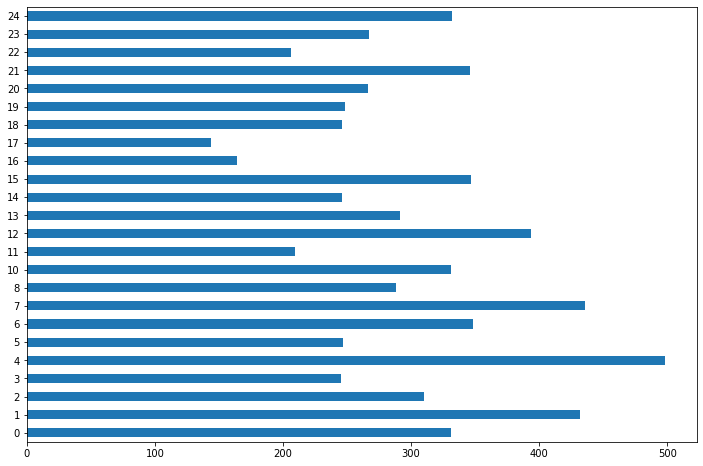

In [6]:
plt.figure(figsize=(12,8))
test['label'].value_counts().sort_index().plot.barh()
plt.show()

In [7]:
train.isna().sum().sum()

0

In [8]:
test.isna().sum().sum()  #minist를 classifier하는 model을 만들어서 testdata에 대한 accuracy가 최대한 높게 나오도록 ..

0

## Train, Test data 전처리


In [ ]:
y_trin=train['label']
y_test=test['label']
del train['label']
del test['label']

In [12]:
x_train = train.values
x_test = test.values

In [13]:
type(x_train)

numpy.ndarray

In [15]:
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

In [16]:
x_train = x_train/255
x_test= x_test/255

In [18]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer() 

In [21]:
y_train = lb.fit_transform(y_trin)
y_test = lb.fit_transform(y_test)

In [25]:
y_train.shape,y_test.shape,x_train.shape, x_test.shape

((27455, 24), (7172, 24), (27455, 28, 28, 1), (7172, 28, 28, 1))

## Train, Test image 확인해보기 (28 X 28 pixel)

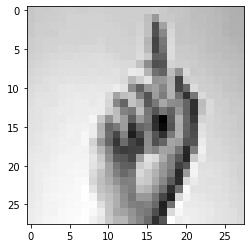

In [37]:
a = np.random.randint(27455) 

img = x_train[a, :,:,:]
plt.imshow(img.reshape(28,28),cmap='gray')
plt.show()

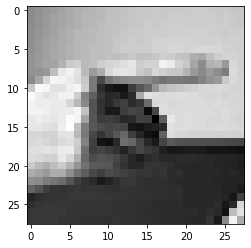

In [43]:
b = np.random.randint(7172) 

img = x_test[b, :,:,:]
plt.imshow(img.reshape(28,28),cmap='gray')
plt.show()

##Data Augmentation

In [45]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [46]:
train_datagen=ImageDataGenerator(rotation_range = 10, zoom_range = 0.1, width_shift_range=0.1, height_shift_range=0.1 )
train_datagen.fit(x_train)

In [47]:
x_train.shape

(27455, 28, 28, 1)

## Model Callbacks 설정하기

In [48]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model

mc = ModelCheckpoint('best_model.h5',monitor='val_acc', verbose=1, mode='max', save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 5)
rlr = ReduceLROnPlateau(monital='val_acc', patience=2, verbose=1, factor=0.5, min_lr=0.00001 )

callbacks = [mc,es,rlr]

## Model 만들기


In [50]:
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization, MaxPool2D
from tensorflow.keras.models import Model, Sequential

In [51]:
model = Sequential()

model.add(Conv2D(75, (3,3), strides=1, padding='same', input_shape=(28,28,1), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides=2, padding='same'))

model.add(Conv2D(50, (3,3), strides=1, padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2),strides=2, padding='same'))

model.add(Conv2D(25,(3,3),strides=1, padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides=2, padding='same'))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(24,activation='softmax'))

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 75)        750       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 75)        300       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 75)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 50)        33800     
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 50)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 50)        200       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 50)          0

In [52]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])

In [54]:
history = model.fit(train_datagen.flow(x_train,y_train, batch_size=128),epochs=20, callbacks=callbacks, verbose=1, validation_data = (x_test,y_test))

Epoch 1/20
215/215 [==============================] - 105s 490ms/step - loss: 0.2100 - acc: 0.9307 - val_loss: 1.3677 - val_acc: 0.5630

Epoch 00001: val_acc improved from -inf to 0.56302, saving model to best_model.h5
Epoch 2/20
215/215 [==============================] - 107s 497ms/step - loss: 0.1061 - acc: 0.9659 - val_loss: 0.0843 - val_acc: 0.9755

Epoch 00002: val_acc improved from 0.56302 to 0.97546, saving model to best_model.h5
Epoch 3/20
215/215 [==============================] - 106s 492ms/step - loss: 0.0610 - acc: 0.9803 - val_loss: 0.0313 - val_acc: 0.9897

Epoch 00003: val_acc improved from 0.97546 to 0.98968, saving model to best_model.h5
Epoch 4/20
215/215 [==============================] - 105s 490ms/step - loss: 0.0423 - acc: 0.9869 - val_loss: 0.0183 - val_acc: 0.9944

Epoch 00004: val_acc improved from 0.98968 to 0.99442, saving model to best_model.h5
Epoch 5/20
215/215 [==============================] - 107s 496ms/step - loss: 0.0379 - acc: 0.9873 - val_loss: 0.27

## Model acc,loss 확인

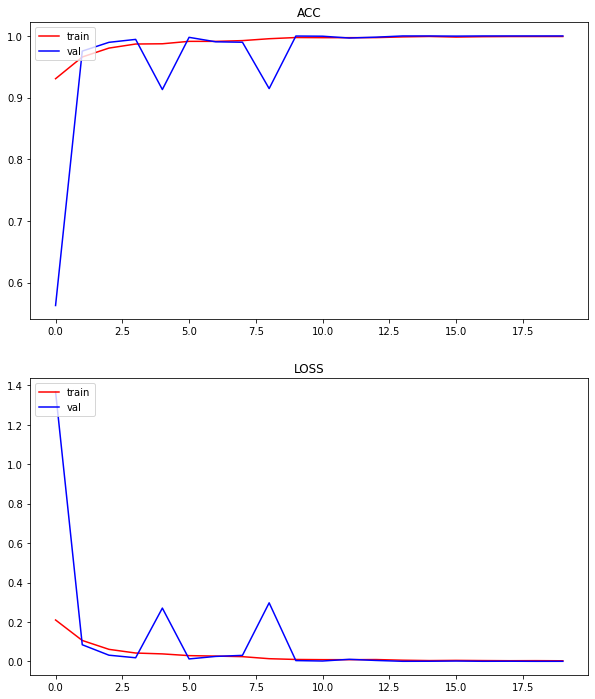

In [57]:
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(10,12))

ax1.plot(history.history['acc'],color='r')
ax1.plot(history.history['val_acc'],color='b')
ax1.set_title("ACC")
ax1.legend(['train','val'],loc='upper left')

ax2.plot(history.history['loss'],color='r')
ax2.plot(history.history['val_loss'],color='b')
ax2.set_title("LOSS")
ax2.legend(['train','val'],loc='upper left')

plt.show()


In [58]:
predictions = model.predict_classes(x_test)
for i in range(len(predictions)):
    if(predictions[i] >= 9):
        predictions[i] += 1
predictions[:5]        

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([ 6,  5, 10,  0,  3])

In [59]:
model.evaluate(x_test,y_test)

225/225 [==============================] - 6s 28ms/step - loss: 3.1059e-04 - acc: 1.0000


[0.000310587405692786, 1.0]